In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D 

%matplotlib notebook

<h2>Question 9.4</h2>

(From Bate's Astrodynamics)

Show how the potential function for the nonspherical Earth would be used in conjunction with Cowell's method. Write out the specific equations would be used in a form suitable for programming.


<h3>Cowell's Method</h3>

Cowell's method involves numerically integrating the 2 body equations of motion with all of the salient perturbations included

$$ \ddot{\mathbf{r}} + \frac{\mu}{r^3}\mathbf{r} = \mathbf{a}_p $$

where the perturbing acceleration $\boldsymbol{a}_p$ could include anything ranging from a third body gravitational contribution or the Earth's obliquity to solar radiation pressure or drag. In 3D space, we'll have 6 second order differential equations to solve, and the perturbing acceleration to compute. In this case we care about the contribution from the "nonspherical Earth," for which we'll need a geopotential (gravity) model as described [here](https://en.wikipedia.org/wiki/Geopotential_model#The_deviations_of_Earth.27s_gravitational_field_from_that_of_a_homogeneous_sphere). Bate supplies one for us based on spherical harmonics in section 9.7, but the wikipedia article provides a better model.

Note that while Cowell's method is conceptually nice--it's not much different from simply integrating the ideal two body problem--there are much more efficient methods.

In [4]:
# constants
mu=3.986004418e5 # km^3 * s^-2
J2=1.75553e10 # km^5 * s^-2 (JGM-3 model)

def eom(t, y, include_pert):
    """ Equations of motion
   
    Arguments
    y: state vector
    a: perturbing acceleration
   
    Return
    ddotr: acceleration
    """
   
    r = y[:3] # position
    v = y[3:] # velocity
    
    # result vector
    res = np.zeros_like(y)
    res[:3] = v
    
    # vector magnitudes
    r_mag = np.linalg.norm(r)
    r_mag7 = r_mag**7
    
    # perturbation term
    pert = j2(r, r_mag) if include_pert else 0
    
    # keplerian acceleration
    a_kep = - (mu * r) / r_mag**3
    
    a = a_kep + pert
    res[3:] = a
    return res

def cowell(t, f, s, steps, include_pert):
    """
    Numerically integrate the equations of motion as specified in the eom function.
    
    Arguments
    t: time (int)
    f: function (eom)
    s: initial state (int[] of length 6)
    steps: amount of steps between initial time and t (int)
    include_pert: whether to include J2 (boolean)
    """
    t_points = np.linspace(0, t, steps)
    sol = solve_ivp(f, [0, t], s, t_eval=t_points, method="DOP853", args=[include_pert])
    y = sol.y.T
    R = y[:, :3]
    V = y[:, 3:]
    return (R, V)

def j2(r, r_mag):
    # vector magnitudes
    r_mag7 = r_mag**7
    x = r[0]
    y = r[1]
    z = r[2]
    x2 = x**2
    y2 = y**2
    z2 = z**2
    
    # perturbation terms for J2
    px = J2 * (x / r_mag7) * (6 * z2 - ((1.5) * (x2 + y2)))
    py = J2 * (y / r_mag7) * (6 * z2 - ((1.5) * (x2 + y2)))
    pz = J2 * (z / r_mag7) * (3 * z2 - ((4.5) * (x2 + y2)))
    a_pert = np.hstack([px, py, pz])
    return a_pert

In [45]:
# WITH J2 PERTURBATION
# time and initial conditions
t = 2500000

# s = [-4.78170000e+04, 2.62202958e-12, 5.23607207e-12, -7.90630527e-16, -5.78145477e-01, -1.15452984e+00]

s =[-6685.20926,601.51244,3346.06634,-1.74294,-6.70242,-2.27739]

#ISS @ Epoch: 2024-148T12:00:00.000Z
#s= [4971.9157485845499, 1279.43260380315, -4452.5654301211998, 1.2212539468405099, 6.7936722869292199, 3.3124158858329902] 

steps = 10000

r, v = cowell(t, eom, s, steps, True)

<IPython.core.display.Javascript object>


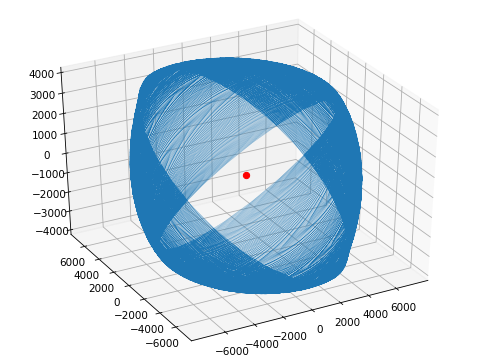

-6685.20926


In [46]:
# plot
fig = plt.figure()
ax = Axes3D(fig)

ax.plot(r.T[0], r.T[1], r.T[2], linewidth=.2)
ax.plot([0], [0], [0], "ro")
print(r.T[0][0])

In [47]:
r_mags = []
v_mags = []
orbit_E = []
for i, j in zip(r,v):
    r_mag = np.sqrt(np.sum(np.square(i)))
    v_mag = np.sqrt(np.sum(np.square(j)))
    E = v_mag**2 / 2 - mu / r_mag
    orbit_E.append(E)
    r_mags.append(r_mag)
    v_mags.append(v_mag)
    
orbit_E = np.floor(orbit_E)

<IPython.core.display.Javascript object>


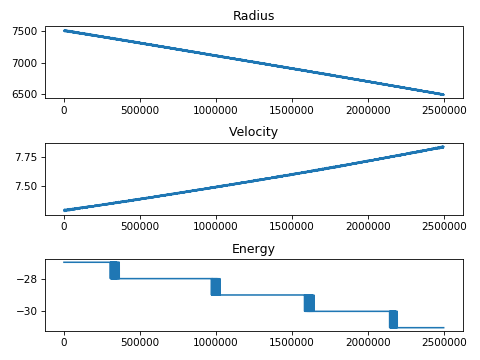

In [48]:
plt.figure()
time = np.linspace(0, t, steps)

plt.subplot(3, 1, 1)
plt.title("Radius")
plt.plot(time, r_mags)

plt.subplot(3, 1, 2)
plt.title("Velocity")
plt.plot(time, v_mags)

plt.subplot(3, 1, 3)
plt.title("Energy")
plt.plot(time, orbit_E)


plt.tight_layout()

In [49]:
# WITHOUT J2 PERTURBATION
# time and initial conditions
r, v = cowell(t, eom, s, steps, False)

<IPython.core.display.Javascript object>


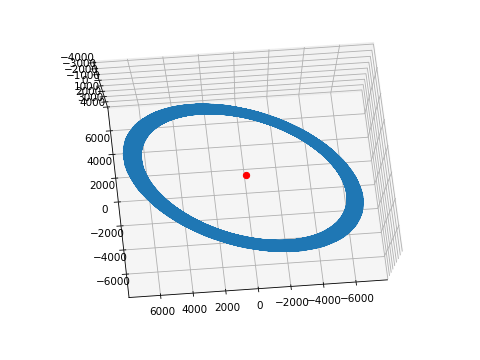

In [51]:
# plot
fig = plt.figure()
ax = Axes3D(fig)

ax.plot(r.T[0], r.T[1], r.T[2], linewidth=1)
ax.plot([0], [0], [0], "ro")

In [52]:
r_mags = []
v_mags = []
orbit_E = []
for i, j in zip(r,v):
    r_mag = np.sqrt(np.sum(np.square(i)))
    v_mag = np.sqrt(np.sum(np.square(j)))
    E = v_mag**2 / 2 - mu / r_mag
    orbit_E.append(E)
    r_mags.append(r_mag)
    v_mags.append(v_mag)
    
orbit_E = np.floor(orbit_E)

<IPython.core.display.Javascript object>


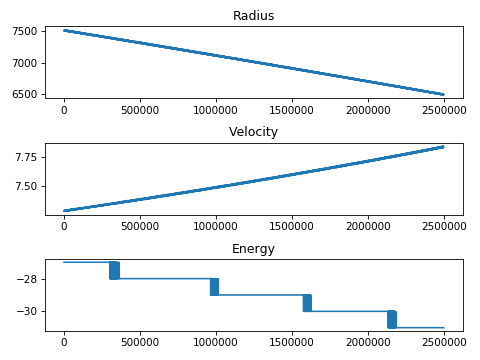

In [53]:
plt.figure()
time = np.linspace(0, t, steps)

plt.subplot(3, 1, 1)
plt.title("Radius")
plt.plot(time, r_mags)

plt.subplot(3, 1, 2)
plt.title("Velocity")
plt.plot(time, v_mags)

plt.subplot(3, 1, 3)
plt.title("Energy")
plt.plot(time, orbit_E)

plt.tight_layout()

<h2>Schaub Question</h2>

(from Spacecraft Relative Motion Kinematics and Kinetics)

Write a numerical simulation of the $J_2$ perturbed inertial orbital motion. Make the code generic enough to integrate the motion of 2 satellites simultaneously.  Demonstrate that your code is working using the following inertial initial condition:

$$\begin{aligned} \mathbf{r}_1(t_0) &= (-6685.20926,601.51244,3346.06634) \\ \dot{\mathbf{r}}_1(t_0) &= (-1.74294,-6.70242,-2.27739) \\ \mathbf{r}_2(t_0) &= (-6685.21657,592.52839,3345.6716) \\ \dot{\mathbf{r}}_2(t_0) &= (-1.74283,-6.70475,-2.27334) \end{aligned} $$

In [54]:
s =[2466.69,5941.54,3282.71,-6.80822,1.04998,3.61939]
r, v = cowell(3600, eom, s, 100, False)
print(r[-1], v[-1])

[-3438.24815206 -7153.81566249 -3756.03161551] [ 5.57306592 -0.92338205 -3.0091847 ]


In [55]:
s =[-6685.20926,601.51244,3346.06634,-1.74294,-6.70242,-2.27739]
r, v = cowell(4848, eom, s, 1000, True)
print(r[-1], v[-1])

[1765.41931036 6894.79827872 2371.11004263] [-6.5073661   0.55778395  3.23540333]


In [56]:
s =[-6685.21657,592.52839,3345.6716,-1.74283,-6.70475,-2.27334]
r, v = cowell(4848, eom, s, 1000, True)
print(r[-1], v[-1])

[1773.24991489 6886.50137177 2358.40311163] [-6.51180082  0.56850944  3.24605586]


In [2]:
import numpy as np

from scipy.integrate import odeint

import matplotlib.pyplot as plt

w = np.sqrt(3)


# function that returns dz/dt

e1_0 = 1

e2_0 = 0

for t in np.linspace(0,10,10001):

    e1 = (e1_0+(-1/w*np.sin(w*(t))*(-((e1_0)*np.cos(w*(t))+(e2_0)/w*np.sin(w*(t)))**3))/1000)

    e2 = (e2_0+(np.cos(w*(t)))*(-((e1_0)*np.cos(w*(t))+(e2_0)/w*np.sin(w*(t)))**3)/1000)

    e1_0 = e1

    e2_0 = e2

ModuleNotFoundError: No module named 'numpy'